# Environment Setup

In [31]:
# library imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm

import tensorflow as tf
import keras

In [2]:
# mount google drive
from google.colab import drive
drive.mount('/content/drive')

data_dir = "/content/drive/MyDrive/spring/deep_learning/data"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# allowing multiple outputs per cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# turn off warnings
import warnings
warnings.filterwarnings('ignore')

In [4]:
# stock under study
TICKER = "AAPL"
LIMIT = 200000

# type of option to study
OPTION = "call"

# Data Loading and Preprocessing

In [5]:
# loading the option pricing data
option_file_path = "{}/{}_{}_options.csv".format(
    data_dir, TICKER, LIMIT
)

option_df = pd.read_csv(option_file_path)
option_df.head()
option_df.tail()
option_df.shape

,date,act_symbol,expiration,strike,call_put,bid,ask,vol,delta,gamma,theta,vega,rho
0,2019-02-09,AAPL,2019-02-22,145.0,Call,25.30,26.05,0.4236,0.9773,0.0038,-0.0371,0.0180,0.0540
1,2019-02-09,AAPL,2019-02-22,145.0,Put,0.06,0.08,0.3886,-0.0149,0.0029,-0.0172,0.0125,-0.0010
2,2019-02-09,AAPL,2019-02-22,152.5,Call,17.90,18.55,0.3267,0.9627,0.0075,-0.0419,0.0271,0.0559
3,2019-02-09,AAPL,2019-02-22,152.5,Put,0.12,0.16,0.3166,-0.0330,0.0070,-0.0274,0.0246,-0.0022
4,2019-02-09,AAPL,2019-02-22,157.5,Call,13.30,13.55,0.2950,0.9208,0.0150,-0.0619,0.0492,0.0550


,date,act_symbol,expiration,strike,call_put,bid,ask,vol,delta,gamma,theta,vega,rho
115189,2025-02-28,AAPL,2025-04-17,280.0,Put,37.80,39.25,0.2781,-0.9582,0.0082,-0.0126,0.0783,-0.0605
115190,2025-02-28,AAPL,2025-04-17,285.0,Call,0.17,0.19,0.2191,0.0254,0.0030,-0.0127,0.0519,0.0078
115191,2025-02-28,AAPL,2025-04-17,285.0,Put,42.80,44.25,0.3035,-0.9613,0.0071,-0.0133,0.0764,-0.0606
115192,2025-02-28,AAPL,2025-04-17,290.0,Call,0.11,0.24,0.2379,0.0231,0.0026,-0.0126,0.0479,0.0071
115193,2025-02-28,AAPL,2025-04-17,290.0,Put,47.80,49.20,0.3236,-0.9680,0.0062,-0.0125,0.0626,-0.0516


(115194, 13)

In [6]:
# loading the stock price data
stock_file_path = "{}/{}_stock.csv".format(
    data_dir, TICKER
)

stock_df = pd.read_csv(stock_file_path)
stock_df.head()

# drop first 2 rows
stock_df = stock_df.iloc[2:, :]
stock_df.reset_index(drop=True, inplace=True)
stock_df.rename(columns={"Price": "date"}, inplace=True)

stock_df.head()
stock_df.tail()
stock_df.shape

,Price,Close,High,Low,Open,Volume
0,Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
1,Date,NaN,NaN,NaN,NaN,NaN
2,2018-01-02,40.47984313964844,40.48924485609061,39.77486500606255,39.98636059756084,102223600
3,2018-01-03,40.47278594970703,41.01797065715718,40.4093405114548,40.543284466801936,118071600
4,2018-01-04,40.66078186035156,40.764179210026526,40.43753953848259,40.545634159903784,89738400


,date,Close,High,Low,Open,Volume
0,2018-01-02,40.47984313964844,40.48924485609061,39.77486500606255,39.98636059756084,102223600
1,2018-01-03,40.47278594970703,41.01797065715718,40.4093405114548,40.543284466801936,118071600
2,2018-01-04,40.66078186035156,40.764179210026526,40.43753953848259,40.545634159903784,89738400
3,2018-01-05,41.123722076416016,41.210668227095155,40.665487033276754,40.75713404190461,94640000
4,2018-01-08,40.970970153808594,41.26705960334316,40.87227008492711,40.970970153808594,82271200


,date,Close,High,Low,Open,Volume
1756,2024-12-24,257.91644287109375,257.92641115938613,255.0096198916901,255.2094124344067,23234700
1757,2024-12-26,258.7355041503906,259.81433504408284,257.34704665632455,257.90642916266114,27237100
1758,2024-12-27,255.30929565429688,258.41589596104086,252.78207543596488,257.54682582842287,42355300
1759,2024-12-30,251.9230194091797,253.22159473829512,250.47461491371794,251.95298524244893,35557500
1760,2024-12-31,250.1449737548828,253.00183336212825,249.15605553782555,252.16275955239965,39480700


(1761, 6)

In [7]:
# loading data for treasury yields
treasury_file_path = "{}/yield-curve-rates-1990-2024.csv".format(
    data_dir
)

treasury_df = pd.read_csv(treasury_file_path)
treasury_df.head()
treasury_df.tail()
treasury_df.shape

,Date,1 Mo,2 Mo,3 Mo,4 Mo,6 Mo,1 Yr,2 Yr,3 Yr,5 Yr,7 Yr,10 Yr,20 Yr,30 Yr
0,12/31/24,4.40,4.39,4.37,4.32,4.24,4.16,4.25,4.27,4.38,4.48,4.58,4.86,4.78
1,12/30/24,4.43,4.42,4.37,4.33,4.25,4.17,4.24,4.29,4.37,4.46,4.55,4.84,4.77
2,12/27/24,4.44,4.43,4.31,4.35,4.29,4.20,4.31,4.36,4.45,4.53,4.62,4.89,4.82
3,12/26/24,4.45,4.45,4.35,4.37,4.31,4.23,4.30,4.35,4.42,4.49,4.58,4.83,4.76
4,12/24/24,4.44,4.44,4.40,4.38,4.30,4.24,4.29,4.36,4.43,4.52,4.59,4.84,4.76


,Date,1 Mo,2 Mo,3 Mo,4 Mo,6 Mo,1 Yr,2 Yr,3 Yr,5 Yr,7 Yr,10 Yr,20 Yr,30 Yr
8752,1/8/90,NaN,NaN,7.79,NaN,7.88,7.81,7.90,7.95,7.92,8.05,8.02,NaN,8.09
8753,1/5/90,NaN,NaN,7.79,NaN,7.85,7.79,7.90,7.94,7.92,8.03,7.99,NaN,8.06
8754,1/4/90,NaN,NaN,7.84,NaN,7.90,7.82,7.92,7.93,7.91,8.02,7.98,NaN,8.04
8755,1/3/90,NaN,NaN,7.89,NaN,7.94,7.85,7.94,7.96,7.92,8.04,7.99,NaN,8.04
8756,1/2/90,NaN,NaN,7.83,NaN,7.89,7.81,7.87,7.90,7.87,7.98,7.94,NaN,8.00


(8757, 14)

In [8]:
# converting Close prices to numeric
stock_df["stock_price"] = pd.to_numeric(stock_df["Close"])

# calculation of historical volatilities
stock_df["return"] = stock_df["stock_price"] / stock_df["stock_price"].shift(1) - 1

# weekly - 5 trading days
stock_df["volatility_week"] = stock_df["return"].rolling(7).std()

# monthly - 21 trading days
stock_df["volatility_month"] = stock_df["return"].rolling(21).std()

# quarterly - 63 trading days
stock_df["volatility_quarter"] = stock_df["return"].rolling(63).std()

In [9]:
# merging the data
option_df["date"] = pd.to_datetime(option_df["date"])
stock_df["date"] = pd.to_datetime(stock_df["date"])

# convert monthly dates to 01 of the month for yields
treasury_df["date"] = pd.to_datetime(treasury_df["Date"])
treasury_df["date"] = pd.to_datetime(
    treasury_df["date"].dt.strftime("%Y-%m-01")
)

df = pd.merge(option_df, stock_df, on="date")

# take most row for the most recent date from treasury yield
treasury_df = treasury_df.sort_values(by="date", ascending=True)
df = pd.merge_asof(df, treasury_df, on="date", direction="backward")

df.head()
df.tail()
df.columns
df.shape

,date,act_symbol,expiration,strike,call_put,bid,ask,vol,delta,gamma,...,4 Mo,6 Mo,1 Yr,2 Yr,3 Yr,5 Yr,7 Yr,10 Yr,20 Yr,30 Yr
0,2019-05-10,AAPL,2019-05-24,167.5,Call,29.55,30.55,0.4562,0.9701,0.0039,...,NaN,2.43,2.3,2.16,2.12,2.15,2.25,2.37,2.63,2.82
1,2019-05-10,AAPL,2019-05-24,167.5,Put,0.16,0.20,0.4440,-0.0267,0.0036,...,NaN,2.43,2.3,2.16,2.12,2.15,2.25,2.37,2.63,2.82
2,2019-05-10,AAPL,2019-05-24,177.5,Call,20.25,20.55,0.3928,0.9219,0.0096,...,NaN,2.43,2.3,2.16,2.12,2.15,2.25,2.37,2.63,2.82
3,2019-05-10,AAPL,2019-05-24,177.5,Put,0.42,0.49,0.3750,-0.0692,0.0092,...,NaN,2.43,2.3,2.16,2.12,2.15,2.25,2.37,2.63,2.82
4,2019-05-10,AAPL,2019-05-24,182.5,Call,15.60,15.85,0.3568,0.8762,0.0148,...,NaN,2.43,2.3,2.16,2.12,2.15,2.25,2.37,2.63,2.82


,date,act_symbol,expiration,strike,call_put,bid,ask,vol,delta,gamma,...,4 Mo,6 Mo,1 Yr,2 Yr,3 Yr,5 Yr,7 Yr,10 Yr,20 Yr,30 Yr
102209,2024-12-31,AAPL,2025-02-21,290.0,Put,38.50,40.55,0.2392,-0.9846,0.0064,...,4.32,4.24,4.16,4.25,4.27,4.38,4.48,4.58,4.86,4.78
102210,2024-12-31,AAPL,2025-02-21,295.0,Call,0.29,0.32,0.2279,0.0366,0.0037,...,4.32,4.24,4.16,4.25,4.27,4.38,4.48,4.58,4.86,4.78
102211,2024-12-31,AAPL,2025-02-21,295.0,Put,44.20,45.60,0.3100,-0.9318,0.0068,...,4.32,4.24,4.16,4.25,4.27,4.38,4.48,4.58,4.86,4.78
102212,2024-12-31,AAPL,2025-02-21,300.0,Call,0.21,0.25,0.2360,0.0277,0.0028,...,4.32,4.24,4.16,4.25,4.27,4.38,4.48,4.58,4.86,4.78
102213,2024-12-31,AAPL,2025-02-21,300.0,Put,48.50,50.55,0.2825,-0.9867,0.0047,...,4.32,4.24,4.16,4.25,4.27,4.38,4.48,4.58,4.86,4.78


Index(['date', 'act_symbol', 'expiration', 'strike', 'call_put', 'bid', 'ask',
       'vol', 'delta', 'gamma', 'theta', 'vega', 'rho', 'Close', 'High', 'Low',
       'Open', 'Volume', 'stock_price', 'return', 'volatility_week',
       'volatility_month', 'volatility_quarter', 'Date', '1 Mo', '2 Mo',
       '3 Mo', '4 Mo', '6 Mo', '1 Yr', '2 Yr', '3 Yr', '5 Yr', '7 Yr', '10 Yr',
       '20 Yr', '30 Yr'],
      dtype='object')

(102214, 37)

In [10]:
# time to expiration in yrs
df["expiration"] = pd.to_datetime(df["expiration"])
df["time_to_maturity"] = pd.to_timedelta(df["expiration"] - df["date"]).dt.days / 365

# selecting risk-free rate
df["short_term_yield"] = df["1 Mo"]
df["long_term_yield"] = df["10 Yr"]

# forward-fill null values for risk-free rate
df["short_term_yield"] = df["short_term_yield"].fillna(method="ffill")
df["long_term_yield"] = df["long_term_yield"].fillna(method="ffill")

# option price to predict
df["option_price"] = (df["bid"] + df["ask"]) / 2

In [11]:
# select the option type
df = df[df["call_put"] == OPTION.title()]

# retain only the relevant columns
df = df[[
    "date", "option_price", "stock_price",
    "strike", "time_to_maturity",
    "volatility_week", "volatility_month", "volatility_quarter",
    "short_term_yield", "long_term_yield"
]]

# set date as index
df.set_index("date", inplace=True)

df.head()
df.shape
df.tail()

,option_price,stock_price,strike,time_to_maturity,volatility_week,volatility_month,volatility_quarter,short_term_yield,long_term_yield
date,,,,,,,,,
2019-05-10,30.050,47.4151,167.5,0.038356,0.012517,0.015871,0.012807,2.4,2.37
2019-05-10,20.400,47.4151,177.5,0.038356,0.012517,0.015871,0.012807,2.4,2.37
2019-05-10,15.725,47.4151,182.5,0.038356,0.012517,0.015871,0.012807,2.4,2.37
2019-05-10,9.325,47.4151,190.0,0.038356,0.012517,0.015871,0.012807,2.4,2.37
2019-05-10,7.450,47.4151,192.5,0.038356,0.012517,0.015871,0.012807,2.4,2.37


(51107, 9)

,option_price,stock_price,strike,time_to_maturity,volatility_week,volatility_month,volatility_quarter,short_term_yield,long_term_yield
date,,,,,,,,,
2024-12-31,1.345,250.144974,275.0,0.142466,0.012282,0.010245,0.010573,4.4,4.58
2024-12-31,0.890,250.144974,280.0,0.142466,0.012282,0.010245,0.010573,4.4,4.58
2024-12-31,0.420,250.144974,290.0,0.142466,0.012282,0.010245,0.010573,4.4,4.58
2024-12-31,0.305,250.144974,295.0,0.142466,0.012282,0.010245,0.010573,4.4,4.58
2024-12-31,0.230,250.144974,300.0,0.142466,0.012282,0.010245,0.010573,4.4,4.58


In [12]:
df.describe()
df.isnull().sum()

,option_price,stock_price,strike,time_to_maturity,volatility_week,volatility_month,volatility_quarter,short_term_yield,long_term_yield
count,51107.000000,51107.000000,51107.000000,51107.000000,51107.000000,51107.000000,51107.000000,51107.000000,51107.000000
mean,15.642276,155.501233,187.833188,0.083731,0.017017,0.017828,0.018602,2.585473,2.739295
std,22.821534,42.675870,76.652864,0.044995,0.009668,0.008579,0.007579,2.412044,1.425491
min,0.000000,47.415100,23.750000,0.027397,0.003436,0.006072,0.009780,0.010000,0.570000
25%,0.380000,128.384323,136.250000,0.043836,0.010844,0.012380,0.012996,0.080000,1.370000
50%,6.350000,153.912186,170.000000,0.076712,0.014470,0.015829,0.017117,2.230000,3.330000
75%,25.300000,181.082794,215.000000,0.126027,0.020681,0.020670,0.021740,5.350000,4.090000
max,408.475000,257.916443,660.000000,0.183562,0.091014,0.066632,0.044385,5.580000,4.830000


,0
option_price,0
stock_price,0
strike,0
time_to_maturity,0
volatility_week,0
volatility_month,0
volatility_quarter,0
short_term_yield,0
long_term_yield,0


Text(0.5, 0.98, 'Histograms for AAPL Call')

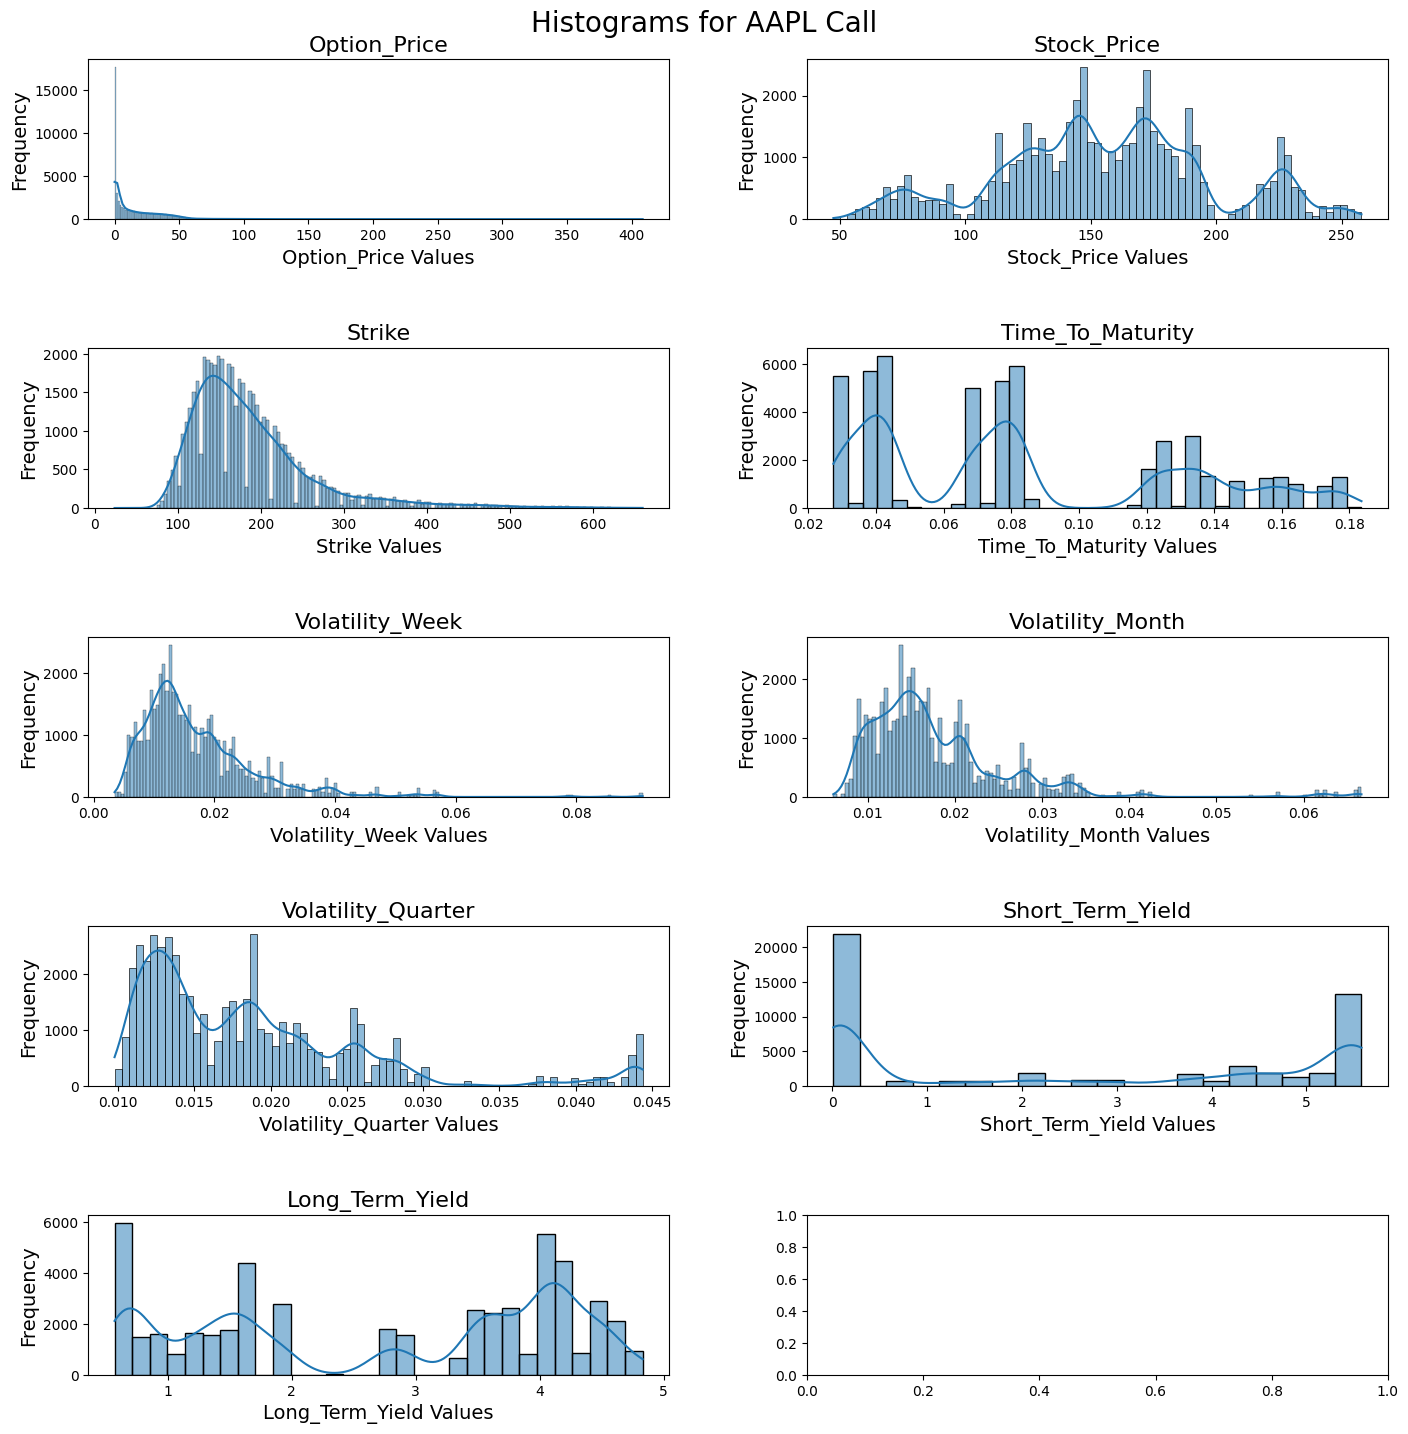

In [13]:
# plotting histograms of the columns
fig, ax = plt.subplots(
    nrows=df.shape[1] // 2 + df.shape[1] % 2,
    ncols=2,
    figsize=(15, 15)
)

for col in df.columns:
    i, j = df.columns.get_loc(col) // 2, df.columns.get_loc(col) % 2
    _ = sns.histplot(
        df[col],
        ax=ax[i, j],
        kde=True
    )
    _ = ax[i, j].set_xlabel("{} Values".format(col.title()), fontsize=14)
    _ = ax[i, j].set_ylabel("Frequency", fontsize=14)
    _ = ax[i, j].set_title("{}".format(col.title()), fontsize=16)

plt.tight_layout(pad=4)
plt.suptitle("Histograms for {} {}".format(TICKER, OPTION.title()), fontsize=20)
plt.show()

Text(0.5, 0.98, 'Trace Plots for AAPL Call')

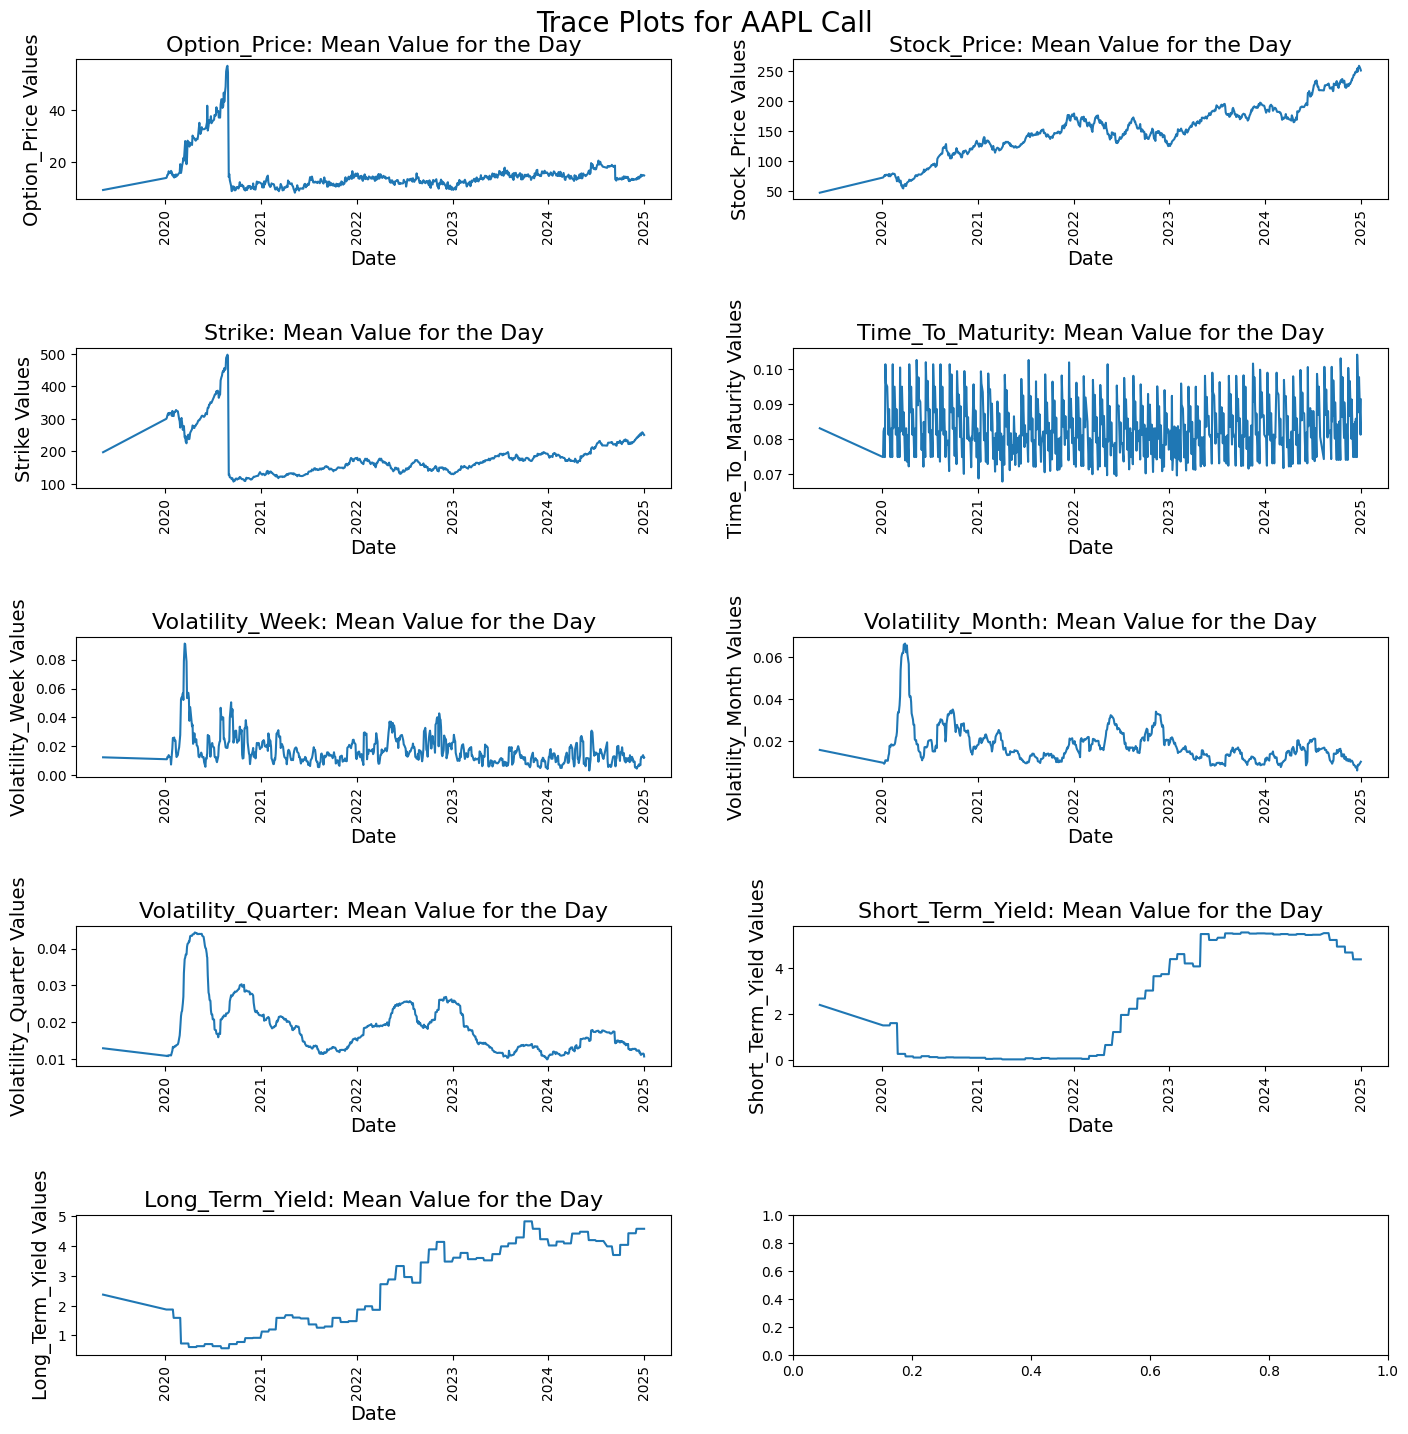

In [18]:
# plotting trace plots for the time series of columns
fig, ax = plt.subplots(
    nrows=df.shape[1] // 2 + df.shape[1] % 2,
    ncols=2,
    figsize=(15, 15)
)

# aggregate cols of df by index
df_agg = df.groupby(df.index).mean()

for col in df.columns:
    i, j = df.columns.get_loc(col) // 2, df.columns.get_loc(col) % 2
    ax[i, j].plot(df_agg.index, df_agg[col])
    _ = ax[i, j].set_xlabel("Date", fontsize=14)
    _ = ax[i, j].set_ylabel("{} Values".format(col.title()), fontsize=14)
    _ = ax[i, j].set_title("{}: Mean Value for the Day".format(col.title()), fontsize=16)
    _ = ax[i, j].tick_params(axis='x', rotation=90)

plt.tight_layout(pad=4)
plt.suptitle("Trace Plots for {} {}".format(TICKER, OPTION.title()), fontsize=20)

# Fitting Models

In [35]:
# partitioning the data temporally
target_col = "option_price"
feature_cols = [
    col for col in df.columns if col != target_col
]

X = df[feature_cols]
y = df[target_col]

test_ratio = 0.2

train_end_date = X.shape[0] * (1 - test_ratio)
X_train = X.iloc[:int(train_end_date)]
X_test = X.iloc[int(train_end_date):]
y_train = y.iloc[:int(train_end_date)]
y_test = y.iloc[int(train_end_date):]

X_train.shape
X_test.shape
y_train.shape
y_test.shape

(40885, 8)

(10222, 8)

(40885,)

(10222,)

In [13]:
# for printing model performance
def print_model_performance(model, X_train, y_train, X_test, y_test, eps=1e-4):
    # MSE
    mse_train = mean_squared_error(y_train, model.predict(X_train))
    mse_test = mean_squared_error(y_test, model.predict(X_test))

    # RMSE
    rmse_train = np.sqrt(mse_train)
    rmse_test = np.sqrt(mse_test)

    print("---In Sample---")
    print("MSE: {:.2f}".format(mse_train))
    print("RMSE: {:.2f}".format(rmse_train))

    print("---Out of Sample---")
    print("MSE: {:.2f}".format(mse_test))
    print("RMSE: {:.2f}".format(rmse_test))

In [14]:
# BSM model functions
def bs_call(S, K, T, r, sigma):
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return S * sp.stats.norm.cdf(d1) - K * np.exp(-r * T) * sp.stats.norm.cdf(d2)

def bs_put(S, K, T, r, sigma):
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return K * np.exp(-r * T) * sp.stats.norm.cdf(-d2) - S * sp.stats.norm.cdf(-d1)

def get_bs_calc(option_type):
    if option_type == "Call":
        return bs_call
    elif option_type == "Put":
        return bs_put
    else:
        raise ValueError("Invalid option type")

In [22]:
# using BSM model for predictions
bsm_model = get_bs_calc(OPTION.title())

S_train = X_train["stock_price"]
K_train = X_train["strike"]
T_train = X_train["time_to_maturity"]
r_train = X_train["short_term_yield"] / 100
sigma_train = X_train["volatility_month"]

S_test = X_test["stock_price"]
K_test = X_test["strike"]
T_test = X_test["time_to_maturity"]
r_test = X_test["short_term_yield"] / 100
sigma_test = X_test["volatility_month"]

y_train_bsm = bsm_model(S_train, K_train, T_train, r_train, sigma_train)
y_test_bsm = bsm_model(S_test, K_test, T_test, r_test, sigma_test)

print("---In Sample---")
print("MSE: {:.2f}".format(mean_squared_error(y_train, y_train_bsm)))
print("RMSE: {:.2f}".format(np.sqrt(mean_squared_error(y_train, y_train_bsm))))

print("---Out of Sample---")
print("MSE: {:.2f}".format(mean_squared_error(y_test, y_test_bsm)))
print("RMSE: {:.2f}".format(np.sqrt(mean_squared_error(y_test, y_test_bsm))))

---In Sample---
MSE: 487.58
RMSE: 22.08
---Out of Sample---
MSE: 4.53
RMSE: 2.13


In [23]:
# fitting a polynomial regression model
poly_reg = make_pipeline(
    StandardScaler(),
    PolynomialFeatures(degree=2),
    LinearRegression()
)

poly_reg.fit(X_train, y_train)

print_model_performance(poly_reg, X_train, y_train, X_test, y_test)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('polynomialfeatures', PolynomialFeatures()),
                ('linearregression', LinearRegression())])

---In Sample---
MSE: 269.90
RMSE: 16.43
---Out of Sample---
MSE: 3672.01
RMSE: 60.60


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 64)                  │             576 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,201 (12.50 KB)

 Trainable params: 3,201 (12.50 KB)

 Non-trainable params: 0 (0.00 B)

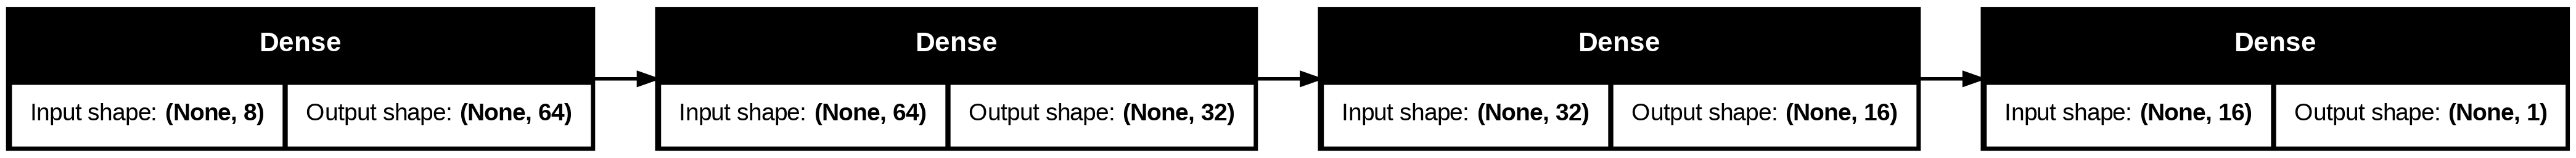

Epoch 1/50
639/639 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - loss: 509.2682 - mse: 509.0937 - val_loss: 8.0422 - val_mse: 7.9069
Epoch 2/50
639/639 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 191.7098 - mse: 191.5749 - val_loss: 7.2077 - val_mse: 7.0708
Epoch 3/50
639/639 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 132.6946 - mse: 132.5557 - val_loss: 3.9115 - val_mse: 3.7650
Epoch 4/50
639/639 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 97.9207 - mse: 97.7717 - val_loss: 32.2948 - val_mse: 32.1355
Epoch 5/50
639/639 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 96.9541 - mse: 96.7917 - val_loss: 1.9442 - val_mse: 1.7719
Epoch 6/50
639/639 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 80.6722 - mse: 80.4969 - val_loss: 4.7247 - val_mse: 4.5372
Epoch 7/50
639/639 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 92.8138 - mse: 92.6218 - val_loss: 2.1036 - val_mse: 1.9012
Epoch 8/50
639/639 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 81.6303 - mse: 81.4246 - val_loss: 2.2989 - val_mse: 2.0808
Epoch 9/50
639/639 ━━━━━━━━━━━━━

In [14]:
# deep fully connected NN
deep_dense = keras.Sequential([
    keras.layers.Dense(
        64, activation="relu", input_shape=[X_train.shape[1]],
        kernel_regularizer=keras.regularizers.l2(0.001),
        bias_regularizer=keras.regularizers.l2(0.01),
        kernel_initializer="he_normal"
    ),
    keras.layers.Dense(
        32, activation="relu",
        kernel_regularizer=keras.regularizers.l2(0.001),
        bias_regularizer=keras.regularizers.l2(0.01),
        kernel_initializer="he_normal"
    ),
    keras.layers.Dense(
        16, activation="relu",
        kernel_regularizer=keras.regularizers.l2(0.001),
        bias_regularizer=keras.regularizers.l2(0.01),
        kernel_initializer="he_normal"
    ),
    keras.layers.Dense(1)
])

deep_dense.summary()
keras.utils.plot_model(deep_dense, show_shapes=True, rankdir="LR")

deep_dense.compile(
    optimizer="adam",
    loss="mse",
    metrics=["mse"]
)

early_stop = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    min_delta=0.1,
    restore_best_weights=True
)

deep_dense_history = deep_dense.fit(
    X_train, y_train, validation_data=(X_test, y_test),
    epochs=50, batch_size=64, verbose=1,
    callbacks=[early_stop]
)

<Figure size 1000x600 with 0 Axes>

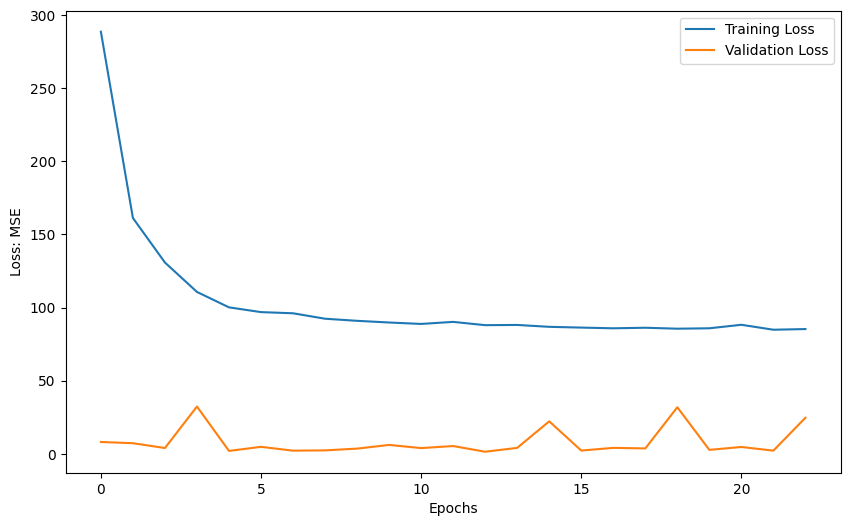

1278/1278 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
320/320 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
---In Sample---
MSE: 83.48
RMSE: 9.14
---Out of Sample---
MSE: 1.08
RMSE: 1.04


In [15]:
# plot loss plot for the model
plt.figure(figsize=(10, 6))
_ = plt.plot(deep_dense_history.history['loss'], label='Training Loss')
_ = plt.plot(deep_dense_history.history['val_loss'], label='Validation Loss')
_ = plt.xlabel('Epochs')
_ = plt.ylabel('Loss: MSE')
_ = plt.legend()
plt.show()

# model performance
print_model_performance(deep_dense, X_train, y_train, X_test, y_test)

In [17]:
# save the deep dense model
deep_dense.save("{}/deep_dense_model.keras".format(data_dir))

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 8)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_16 (Dense)          │ (None, 32)             │            288 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda_2 (Lambda)         │ (None, 1, 32)          │              0 │ dense_16[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda_3 (Lambda)         │ (None, 8, 32)          │              0 │ lambda_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention_4    │ (None, 8, 32)          │         16,800 │ lambda_3[0][0],        │
│ (MultiHeadAttention)      │                        │                │ lambda_3[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_15 (Dropout)      │ (None, 8, 32)          │              0 │ multi_head_attention_… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_8 (Add)               │ (None, 8, 32)          │              0 │ lambda_3[0][0],        │
│                           │                        │                │ dropout_15[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_8     │ (None, 8, 32)          │             64 │ add_8[0][0]            │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_17 (Dense)          │ (None, 8, 32)          │          1,056 │ layer_normalization_8… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_16 (Dropout)      │ (None, 8, 32)          │              0 │ dense_17[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_18 (Dense)          │ (None, 8, 32)          │          1,056 │ dropout_16[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_9 (Add)               │ (None, 8, 32)          │              0 │ layer_normalization_8… │
│                           │                        │                │ dense_18[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_9     │ (None, 8, 32)          │             64 │ add_9[0][0]            │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention_5    │ (None, 8, 32)          │         16,800 │ layer_normalization_9… │
│ (MultiHeadAttention)      │                        │                │ layer_normalization_9… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_18 (Dropout)      │ (None, 8, 32)          │              0 │ multi_head_attention_… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_10 (Add)              │ (None, 8, 32)          │              0 │ layer_normalization_9… │
│                      

 Total params: 95,009 (371.13 KB)

 Trainable params: 95,009 (371.13 KB)

 Non-trainable params: 0 (0.00 B)

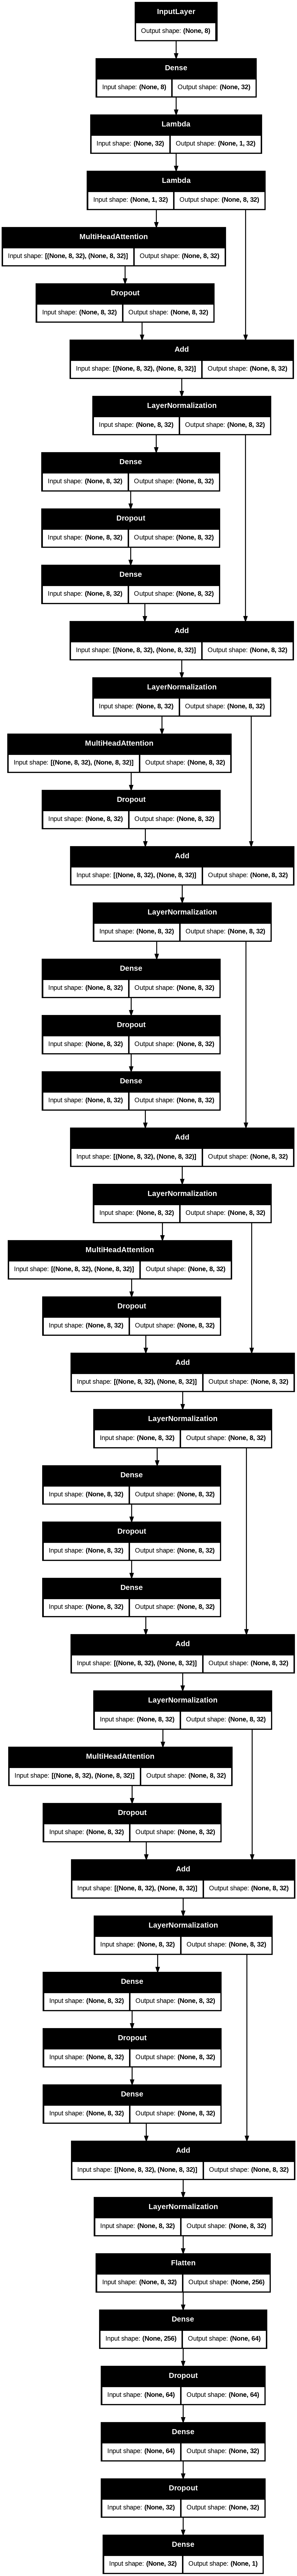

Epoch 1/50
256/256 ━━━━━━━━━━━━━━━━━━━━ 56s 67ms/step - loss: 515.8221 - mse: 512.0053 - val_loss: 32.7751 - val_mse: 29.1294
Epoch 2/50
256/256 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - loss: 159.1578 - mse: 155.5099 - val_loss: 24.6241 - val_mse: 20.9887
Epoch 3/50
256/256 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 153.6974 - mse: 150.0717 - val_loss: 16.4330 - val_mse: 12.8380
Epoch 4/50
256/256 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 119.5589 - mse: 115.9769 - val_loss: 35.6765 - val_mse: 32.1234
Epoch 5/50
256/256 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 141.7384 - mse: 138.2021 - val_loss: 25.3148 - val_mse: 21.8045
Epoch 6/50
256/256 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 108.5453 - mse: 105.0541 - val_loss: 32.0568 - val_mse: 28.6094
Epoch 7/50
256/256 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 149.9847 - mse: 146.5499 - val_loss: 35.2771 - val_mse: 31.8621
Epoch 8/50
256/256 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 96.3824 - mse: 92.9813 - val_loss: 17.9109 - val_mse: 14.5330
Ep

In [18]:
# tab transformer
num_features = X_train.shape[1]
embedding_dim = 32
num_heads = 4
ff_dim = 32
num_transformer_blocks = 4
mlp_hidden_units = [64, 32]
dropout_rate = 0.1

inputs = keras.Input(shape=(num_features,))
embedded_features = keras.layers.Dense(
    embedding_dim, activation='relu',
    kernel_initializer=keras.initializers.GlorotUniform(),
    kernel_regularizer=keras.regularizers.l2(0.01)
)(inputs)
embedded_features = keras.layers.Lambda(
    lambda x: tf.expand_dims(x, axis=1)
)(embedded_features)
embedded_features = keras.layers.Lambda(
    lambda x: tf.tile(x, [1, num_features, 1])
)(embedded_features)

for _ in range(num_transformer_blocks):
    attention_output = keras.layers.MultiHeadAttention(
        num_heads=num_heads,
        key_dim=embedding_dim
    )(embedded_features, embedded_features)
    attention_output = keras.layers.Dropout(dropout_rate)(attention_output)

    x = keras.layers.Add()([embedded_features, attention_output])
    x = keras.layers.LayerNormalization(epsilon=1e-6)(x)

    ff_output = keras.layers.Dense(
        ff_dim, activation='relu',
        kernel_regularizer=keras.regularizers.l2(0.01),
        kernel_initializer=keras.initializers.GlorotUniform()
    )(x)
    ff_output = keras.layers.Dropout(dropout_rate)(ff_output)
    ff_output = keras.layers.Dense(
        embedding_dim, activation='relu',
        kernel_regularizer=keras.regularizers.l2(0.01),
        kernel_initializer=keras.initializers.GlorotUniform()
    )(ff_output)

    embedded_features = keras.layers.Add()([x, ff_output])
    embedded_features = keras.layers.LayerNormalization(epsilon=1e-6)(embedded_features)

x = keras.layers.Flatten()(embedded_features)
for units in mlp_hidden_units:
    x = keras.layers.Dense(
        units, activation='relu',
        kernel_regularizer=keras.regularizers.l2(0.01),
        kernel_initializer=keras.initializers.GlorotUniform()
    )(x)
    x = keras.layers.Dropout(dropout_rate)(x)

outputs = keras.layers.Dense(1)(x)

tab_trans_model = keras.Model(inputs=inputs, outputs=outputs)
tab_trans_model.compile(optimizer='adam', loss='mse', metrics=["mse"])

tab_trans_model.summary()
keras.utils.plot_model(tab_trans_model, show_shapes=True)

early_stop = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    min_delta=0.1,
    restore_best_weights=True
)
tab_trans_model_history = tab_trans_model.fit(
    X_train, y_train, validation_data=(X_test, y_test),
    epochs=50, batch_size=160, verbose=1,
    callbacks=[early_stop]
)

<Figure size 1000x600 with 0 Axes>

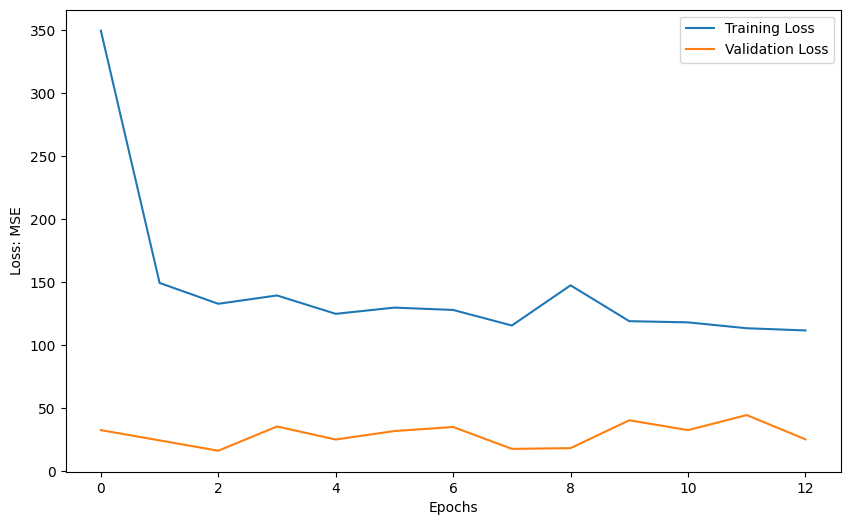

1278/1278 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step
320/320 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
---In Sample---
MSE: 107.28
RMSE: 10.36
---Out of Sample---
MSE: 12.84
RMSE: 3.58


In [20]:
# plot loss plot for the model
plt.figure(figsize=(10, 6))
_ = plt.plot(tab_trans_model_history.history['loss'], label='Training Loss')
_ = plt.plot(tab_trans_model_history.history['val_loss'], label='Validation Loss')
_ = plt.xlabel('Epochs')
_ = plt.ylabel('Loss: MSE')
_ = plt.legend()
plt.show()

# model performance
print_model_performance(tab_trans_model, X_train, y_train, X_test, y_test)

# Error Analysis

In [18]:
# retrieve the best model: deep dense
model = keras.models.load_model("{}/deep_dense_model.keras".format(data_dir))

In [26]:
# get the residuals for the best model
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# reshape into 1D arrays
y_train_pred = y_train_pred.reshape(-1)
y_test_pred = y_test_pred.reshape(-1)

y_train.shape
y_test.shape
y_train_pred.shape
y_test_pred.shape

res_test = y_test - y_test_pred
res_train = y_train - y_train_pred

1278/1278 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


(40885,)

(10222,)

(40885,)

(10222,)

Text(0.5, 0.98, 'Residuals against Features: Training')

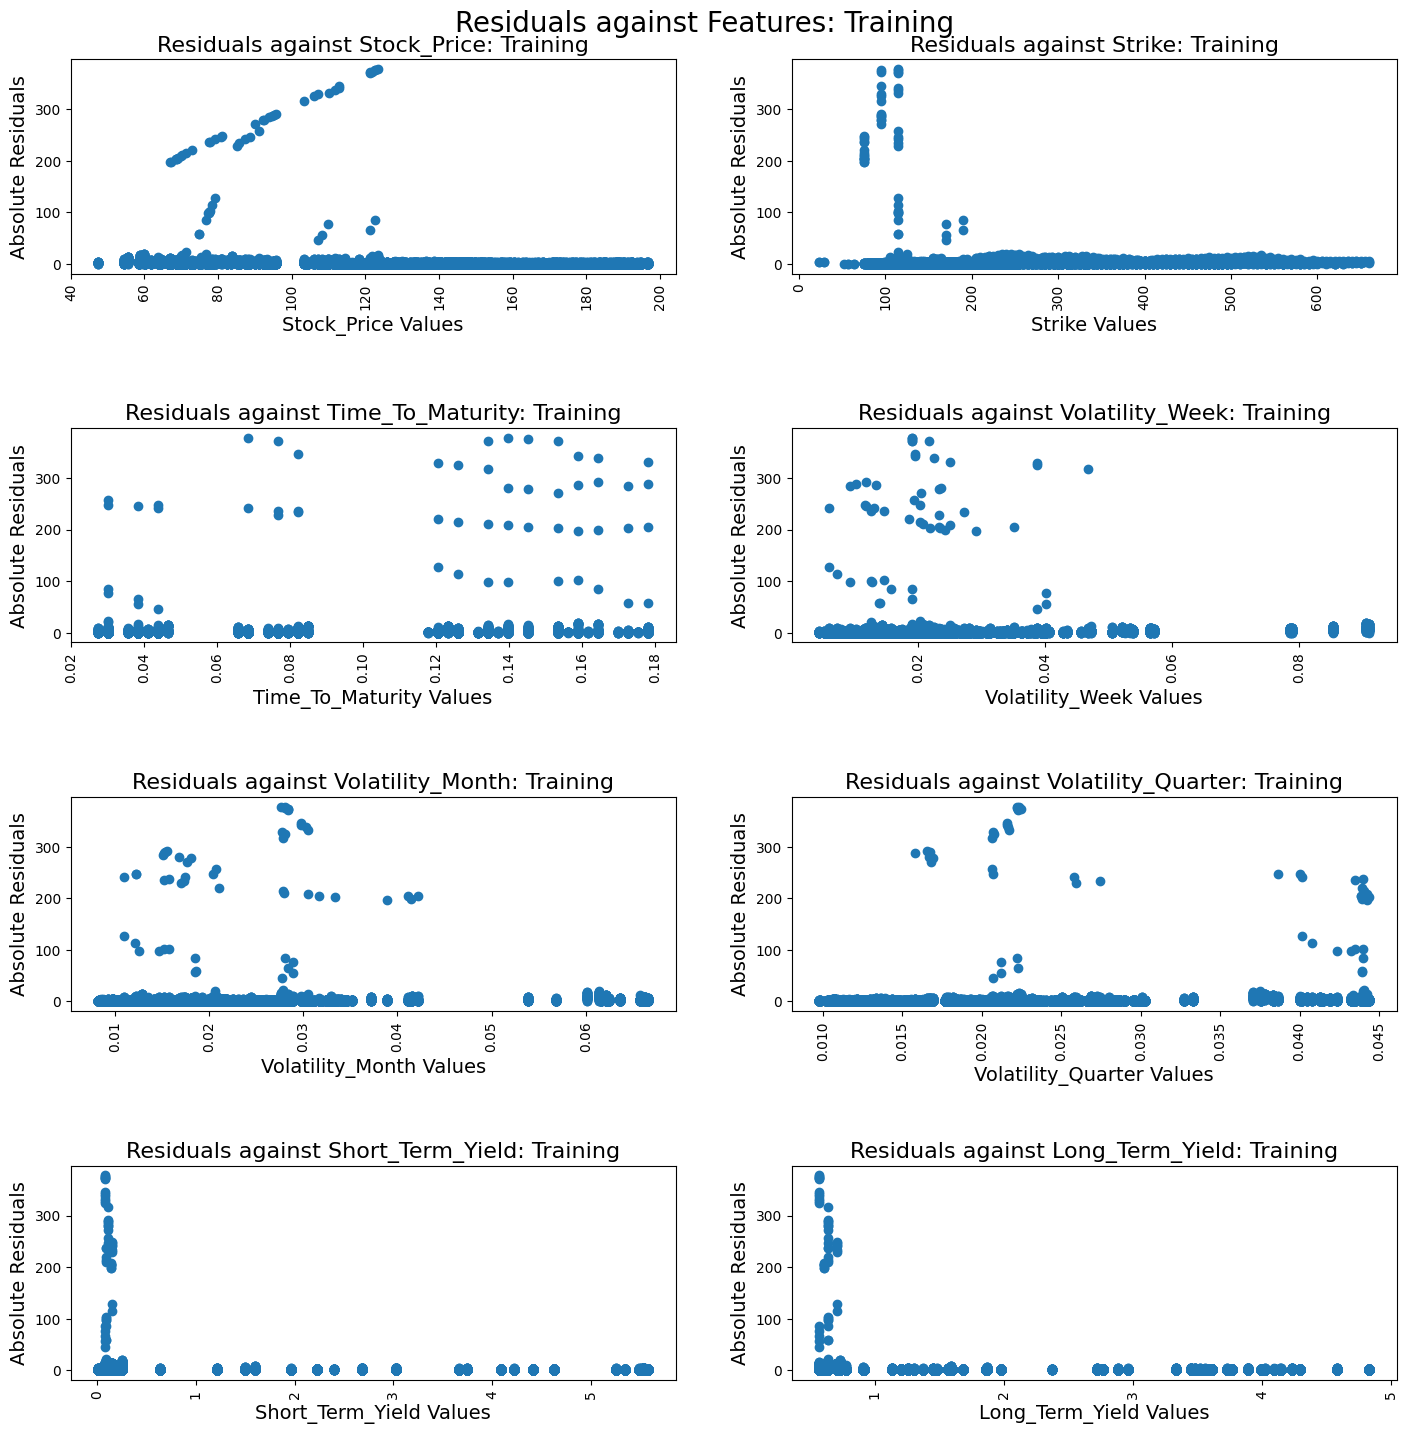

Text(0.5, 0.98, 'Residuals against Features: Testing')

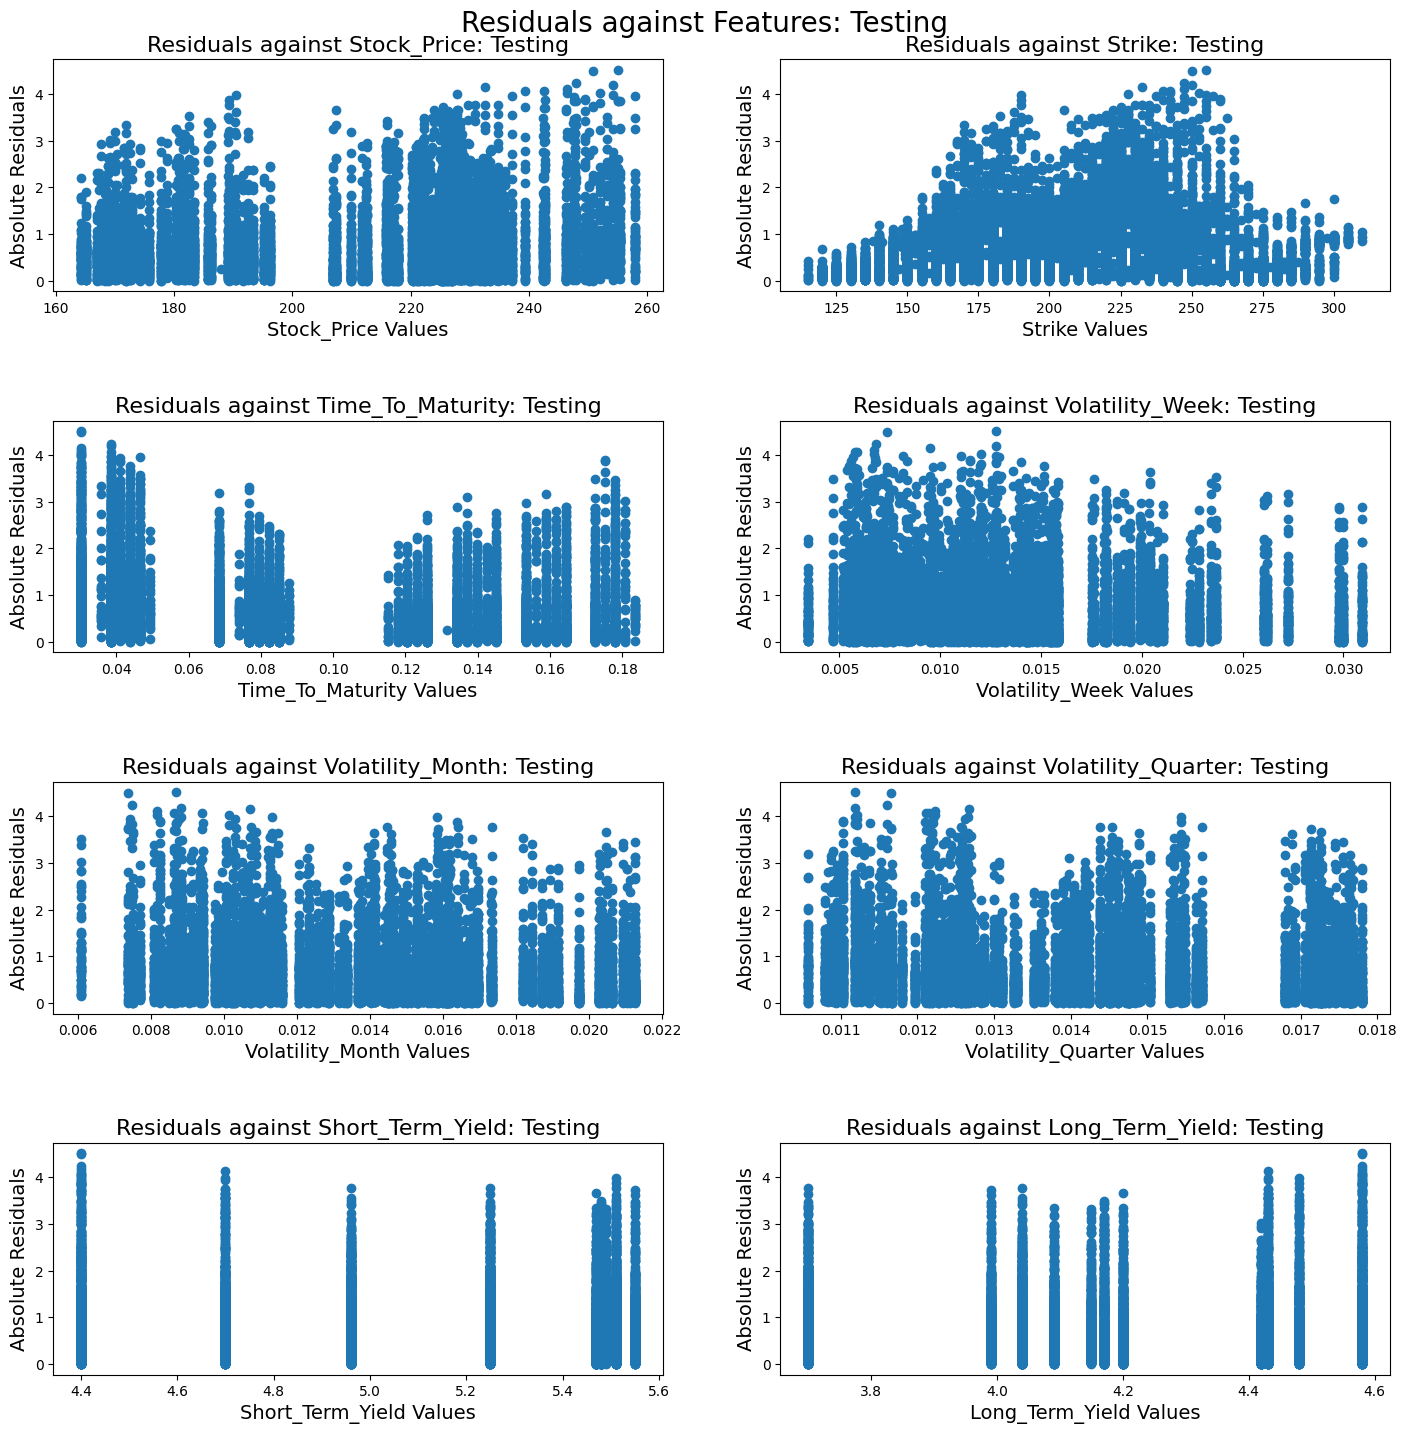

In [33]:
# plotting absolute residuals against the different features
fig, ax = plt.subplots(
    nrows=X_train.shape[1] // 2 + X_train.shape[1] % 2,
    ncols=2,
    figsize=(15, 15)
)

for col in X_train.columns:
    i, j = X_train.columns.get_loc(col) // 2, X_train.columns.get_loc(col) % 2
    _ = ax[i, j].scatter(X_train[col], np.abs(res_train))
    _ = ax[i, j].set_xlabel("{} Values".format(col.title()), fontsize=14)
    _ = ax[i, j].set_ylabel("Absolute Residuals", fontsize=14)
    _ = ax[i, j].set_title("Residuals against {}: Training".format(col.title()), fontsize=16)
    _ = ax[i, j].tick_params(axis='x', rotation=90)

plt.tight_layout(pad=4)
plt.suptitle("Residuals against Features: Training", fontsize=20)
plt.show()

fig, ax = plt.subplots(
    nrows=X_test.shape[1] // 2 + X_test.shape[1] % 2,
    ncols=2,
    figsize=(15, 15)
)
for col in X_test.columns:
    i, j = X_test.columns.get_loc(col) // 2, X_test.columns.get_loc(col) % 2
    _ = ax[i, j].scatter(X_test[col], np.abs(res_test))
    _ = ax[i, j].set_xlabel("{} Values".format(col.title()), fontsize=14)
    _ = ax[i, j].set_ylabel("Absolute Residuals", fontsize=14)
    _ = ax[i, j].set_title("Residuals against {}: Testing".format(col.title()), fontsize=16)

plt.tight_layout(pad=4)
plt.suptitle("Residuals against Features: Testing", fontsize=20)
plt.show()

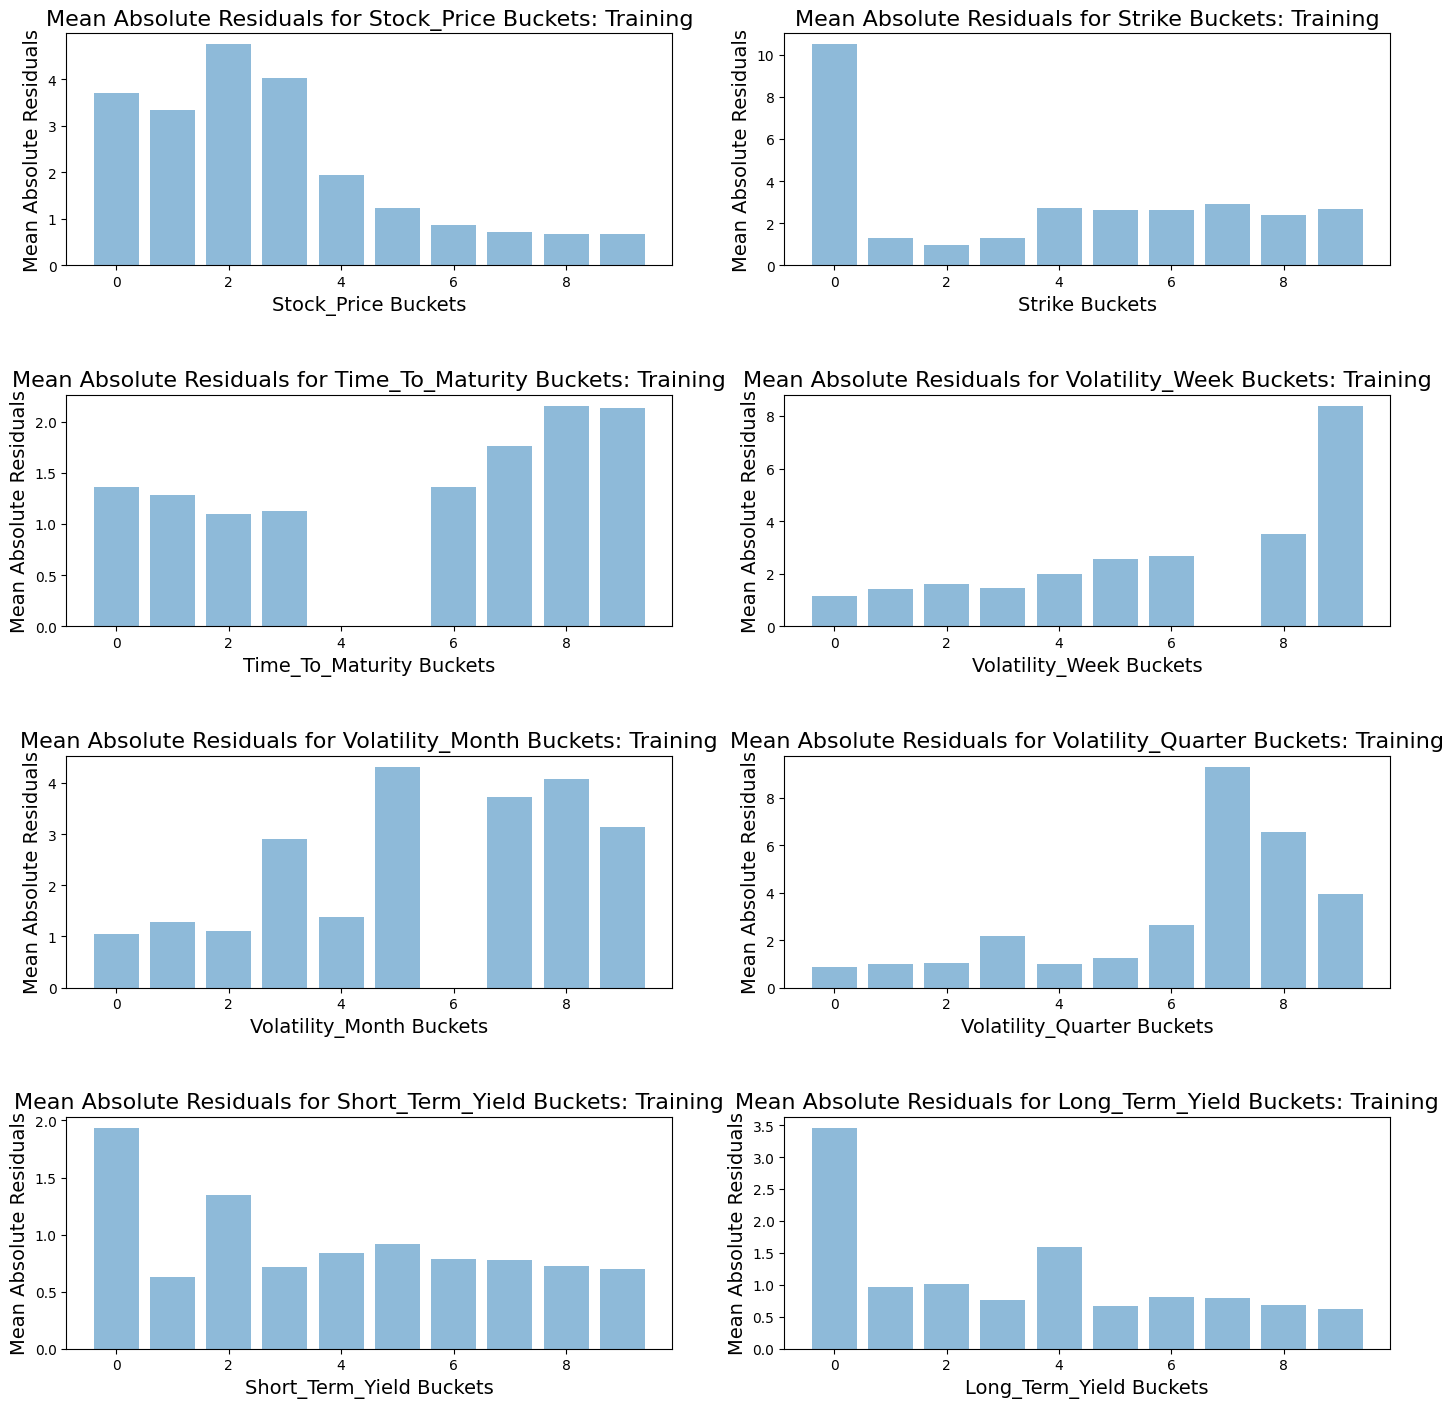

In [36]:
# create 10 buckets of values for each col
X_train_analysis = X_train.copy()
X_test_analysis = X_test.copy()

for col in X_train.columns:
    X_train_analysis[col + "_bucketed"] = pd.cut(X_train[col], 10, labels=False)
    X_test_analysis[col + "_bucketed"] = pd.cut(X_test[col], 10, labels=False)

# bar graph of mean values of absolute residuals for each bucket
fig, ax = plt.subplots(
    nrows=X_train.shape[1] // 2 + X_train.shape[1] % 2,
    ncols=2,
    figsize=(15, 15)
)

for col in X_train.columns:
    i, j = X_train_analysis.columns.get_loc(col) // 2, X_train_analysis.columns.get_loc(col) % 2
    _ = ax[i, j].bar(
        X_train_analysis[col + "_bucketed"].value_counts().sort_index().index,
        np.abs(res_train).groupby(X_train_analysis[col + "_bucketed"]).mean(),
        alpha=0.5
    )
    _ = ax[i, j].set_xlabel("{} Buckets".format(col.title()), fontsize=14)
    _ = ax[i, j].set_ylabel("Mean Absolute Residuals", fontsize=14)
    _ = ax[i, j].set_title("Mean Absolute Residuals for {} Buckets: Training".format(col.title()), fontsize=16)

plt.tight_layout(pad=4)
plt.show()